In [10]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import argparse
import sys
import numpy as np
from skimage.transform import resize
import matplotlib.pyplot as plt

from tensorflow.examples.tutorials.mnist import input_data

import tensorflow as tf

FLAGS = None

In [2]:
rng = np.random.RandomState()
crop = 8
ds_factor = 2.

def new_shape(crop, ds_factor):
    return int(np.around((28 - crop) / ds_factor))

def transform(X, crop=2, ds_factor=2.):
    Xp = X.reshape(X.shape[0], 28, 28)
    Xp = Xp[:, crop:28-crop, crop:28-crop]
    new = new_shape(crop, ds_factor)
    Xp = resize(Xp, (Xp.shape[0], new, new))
    return Xp.reshape(Xp.shape[0], -1)

In [3]:
mnist = input_data.read_data_sets('/tmp/tensorflow/mnist/input_data/', one_hot=True)
new_dim = new_shape(crop, ds_factor) **2
# Create the model
x = tf.placeholder(tf.float32, [None, new_dim])
p = tf.Variable(tf.zeros((new_dim * 10) + 10))
W = tf.reshape(p[:new_dim * 10], [new_dim, 10])
b = tf.reshape(p[new_dim * 10:], [10])

y = tf.matmul(x, W) + b

# Define loss and optimizer
y_ = tf.placeholder(tf.float32, [None, 10])

cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_, logits=y))

Extracting /tmp/tensorflow/mnist/input_data/train-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/train-labels-idx1-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-images-idx3-ubyte.gz
Extracting /tmp/tensorflow/mnist/input_data/t10k-labels-idx1-ubyte.gz


In [29]:
opt = tf.train.GradientDescentOptimizer(learning_rate=1.)
grad, var = opt.compute_gradients(cross_entropy, var_list=[p])[0]
grad2 = tf.reshape(grad, (grad.shape[0], 1))

# Meaningless outside pixel make Hessian not invertable, cropping would fix need for tf.eye
hess = tf.squeeze(tf.hessians(cross_entropy, p)) #+ .0001 * tf.eye((new_dim * 10) + 10)
e = tf.squeeze(tf.self_adjoint_eigvals(tf.expand_dims(hess, axis=0)))[::-1]
grad_prime = tf.squeeze(tf.matmul(tf.matrix_inverse(hess), grad2))
train_step = opt.apply_gradients([(grad_prime, var)])

In [32]:
sess = tf.InteractiveSession()
tf.global_variables_initializer().run()

/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


0.098
0.0995



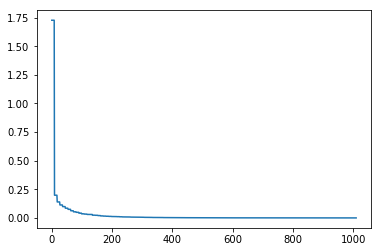

training
0.0778
0.094



InvalidArgumentError: Input is not invertible.
	 [[Node: MatrixInverse_3 = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Squeeze_10)]]

Caused by op 'MatrixInverse_3', defined at:
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-29-83d3956310cb>", line 8, in <module>
    grad_prime = tf.squeeze(tf.matmul(tf.matrix_inverse(hess), grad2))
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/tensorflow/python/ops/gen_linalg_ops.py", line 599, in matrix_inverse
    "MatrixInverse", input=input, adjoint=adjoint, name=name)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/home/jesse/anaconda3/envs/tensorflow35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Input is not invertible.
	 [[Node: MatrixInverse_3 = MatrixInverse[T=DT_FLOAT, adjoint=false, _device="/job:localhost/replica:0/task:0/device:GPU:0"](Squeeze_10)]]


In [33]:
plt.close()
correct_prediction = tf.equal(tf.argmax(y, 1), tf.argmax(y_, 1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

print(sess.run(accuracy, feed_dict={x: transform(mnist.test.images, crop, ds_factor),
                                  y_: mnist.test.labels}))
print(sess.run(accuracy, feed_dict={x: transform(batch_xs, crop, ds_factor), y_: batch_ys}))
plt.figure()
plt.plot(sess.run(e, feed_dict={x: transform(batch_xs, crop, ds_factor), y_: batch_ys}))
print()
plt.show()

# Train
print('training')
for ii in range(50000):
    batch_xs, batch_ys = mnist.train.next_batch(2000)
    sess.run(train_step, feed_dict={x: transform(batch_xs, crop, ds_factor), y_: batch_ys})
    if ii % 100 == 0:
        print(sess.run(accuracy, feed_dict={x: transform(mnist.test.images, crop, ds_factor),
                                  y_: mnist.test.labels}))
        print(sess.run(accuracy, feed_dict={x: transform(batch_xs, crop, ds_factor), y_: batch_ys}))
        plt.figure()
        plt.plot(sess.run(e, feed_dict={x: transform(batch_xs, crop, ds_factor), y_: batch_ys}))
        print()

print('test')
print(sess.run(accuracy, feed_dict={x: transform(mnist.test.images, crop, ds_factor),
                                  y_: mnist.test.labels}))